# ***Global Terrosism Dataset - Analyzing the API***
---

## **Dependencies**
Se importa la libreria pandas para el analisis.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Esta celda de código carga un archivo CSV llamado globalterrorismdb_0718dist.csv desde la ruta especificada en el directorio local. Utiliza la librería pandas y asigna los datos al DataFrame df_terrorism.

## **Original Dataset Transformations**

**NOTA:** El analisis se hará teniendo en cuenta los csvs originales, esto por el tema de que la API no consuma más de la cuenta, por lo que al ejecutar la API se crea una coia de seguridad con la que se realizará este EDA

In [2]:
df_terrorism = pd.read_csv('C:/Users/LENOVO/Documents/GitHub/GlobalTerrorismAnalysis_ETL/data/globalterrorismdb_0718dist.csv', encoding='iso-8859-1', low_memory=False)

In [3]:
columns_choice = [
    "eventid",
    "iyear",
    "imonth",
    "iday",
    "extended",
    "country_txt",
    "country",
    "region_txt",
    "region",
    "city",
    "latitude",
    "longitude",
    "vicinity",
    "crit1",
    "crit2",
    "crit3",
    "doubtterr",
    "multiple",
    "success",
    "suicide",
    "attacktype1_txt",
    "attacktype1",
    "targtype1_txt",
    "targtype1",
    "natlty1_txt",
    "natlty1",
    "gname",
    "guncertain1",
    "individual",
    "nperps",
    "nperpcap",
    "claimed",
    "weaptype1_txt",
    "weaptype1",
    "nkill",
    "property",
    "ishostkid",
    "nwound",
    "INT_ANY"
]

In [4]:
defect_values = {
    'nperpcap':0,
    'claimed': 999,
    'nkill':0
}

In [5]:
df_terrorism = df_terrorism.fillna(value=defect_values)

In [6]:
df_terrorism = df_terrorism[df_terrorism['doubtterr'] != 1]
df_terrorism = df_terrorism[df_terrorism['doubtterr'] != -9]
df_terrorism = df_terrorism[df_terrorism['iday'] != 0]

In [7]:
df_terrorism = df_terrorism[columns_choice]
df_terrorism = df_terrorism.dropna()

In [8]:
# Asegurarse de que las columnas 'iyear', 'imonth' y 'iday' no tengan valores nulos
df_terrorism = df_terrorism.dropna(subset=['iyear', 'imonth', 'iday'])

df_terrorism['date'] = pd.to_datetime(df_terrorism[['iyear', 'imonth', 'iday']].rename(columns={'iyear': 'year', 'imonth': 'month', 'iday': 'day'}))

# Crear la columna 'date_country'
df_terrorism['date_country_actor'] = df_terrorism['date'].astype(str) + df_terrorism['country_txt'] + df_terrorism['gname']

print(df_terrorism.head())

         eventid  iyear  imonth  iday  extended    country_txt  country  \
5   197001010002   1970       1     1         0  United States      217   
6   197001020001   1970       1     2         0        Uruguay      218   
8   197001020003   1970       1     2         0  United States      217   
9   197001030001   1970       1     3         0  United States      217   
13  197001090001   1970       1     9         0  United States      217   

       region_txt  region        city  ...  claimed  weaptype1_txt  weaptype1  \
5   North America       1       Cairo  ...      0.0       Firearms          5   
6   South America       3  Montevideo  ...    999.0       Firearms          5   
8   North America       1     Madison  ...      1.0     Incendiary          8   
9   North America       1     Madison  ...      0.0     Incendiary          8   
13  North America       1     Detroit  ...      0.0     Incendiary          8   

    nkill  property  ishostkid  nwound  INT_ANY       date  \


Lo anterior podría realizarse como una solución al merge, a través de la creación de una llave compuesta en el que incluimos fecha, país y grupo terrorista.

In [9]:
df_terrorism.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82969 entries, 5 to 181690
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   eventid             82969 non-null  int64         
 1   iyear               82969 non-null  int64         
 2   imonth              82969 non-null  int64         
 3   iday                82969 non-null  int64         
 4   extended            82969 non-null  int64         
 5   country_txt         82969 non-null  object        
 6   country             82969 non-null  int64         
 7   region_txt          82969 non-null  object        
 8   region              82969 non-null  int64         
 9   city                82969 non-null  object        
 10  latitude            82969 non-null  float64       
 11  longitude           82969 non-null  float64       
 12  vicinity            82969 non-null  int64         
 13  crit1               82969 non-null  int64         

## **API Analysis**

En el caso de la API, nos interesan sus columnas event_date (para la creación de una llave compuesta), country (para la creación de una llave compuesta), disorder_type (para sumarle otra dimension a nuestra tabla de hecho que nos proporcione más contexto) y actor1 (para la creación de una llave compuesta). 

In [10]:
api_terrorism = pd.read_csv('C:/Users/LENOVO/Documents/GitHub/GlobalTerrorismAnalysis_ETL/data/combined_data.csv')

In [11]:
print(api_terrorism.isnull().sum())
api_terrorism = api_terrorism.dropna()

event_date       0
country          0
disorder_type    0
actor1           0
dtype: int64


Vemos positivo que la API este 100% completa

In [12]:
api_terrorism['date_country_actor'] = api_terrorism['event_date'].astype(str) + api_terrorism['country'] + api_terrorism['actor1']

Este código crea una nueva columna en el DataFrame api_terrorism llamada date_country_actor. La columna es el resultado de concatenar tres columnas existentes: event_date (convertido a cadena de texto), country y actor1. Esta nueva columna combina la fecha del evento, el país y el actor principal en un único valor. Todo esto con el objetivo de crear una llave compuesta para realizar el merge

In [13]:
api_terrorism.head(2)

,event_date,country,disorder_type,actor1,date_country_actor
0,2010-12-31,Nigeria,Political violence,Unidentified Armed Group (Nigeria),2010-12-31NigeriaUnidentified Armed Group (Nig...
1,2010-12-31,Pakistan,Demonstrations,Protesters (Pakistan),2010-12-31PakistanProtesters (Pakistan)


In [14]:
api_terrorism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392371 entries, 0 to 392370
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   event_date          392371 non-null  object
 1   country             392371 non-null  object
 2   disorder_type       392371 non-null  object
 3   actor1              392371 non-null  object
 4   date_country_actor  392371 non-null  object
dtypes: object(5)
memory usage: 15.0+ MB


In [24]:
api_terrorism.describe()

,event_date,country,disorder_type,actor1,date_country_actor
count,392371,392371,392371,392371,392371
unique,7659,77,4,5480,167276
top,2017-01-18,Pakistan,Political violence,Protesters (Pakistan),2016-11-28IndiaProtesters (India)
freq,493,45997,242677,30641,138


Podemos observar que, a pesar de tener apróximadamente 390 mil datos, puede ser posible que esa gran cantidad de ataques cometidos, sean cometidos por pocos grupos terroristas, y en fechas frecuentes (teniendo en cuenta el unique de la columna event_date y actor1)

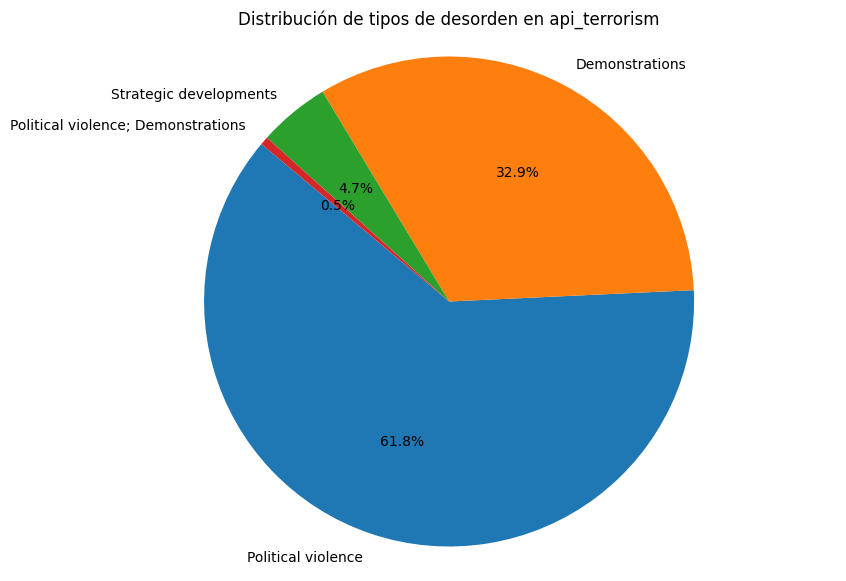

In [23]:
disorder_counts = api_terrorism['disorder_type'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(disorder_counts, labels=disorder_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de tipos de desorden en api_terrorism')
plt.axis('equal')  
plt.show()

Vemos que, en su gran mayoría, el tipo de desorder suele ser por violencia política, lo que nos puede dar un indicio de que la mayoría de los posibles atentados resultantes en el merge se puedan analizar de forma más profunda, encontrando motivos con mucho más contexto y analizar sus variables

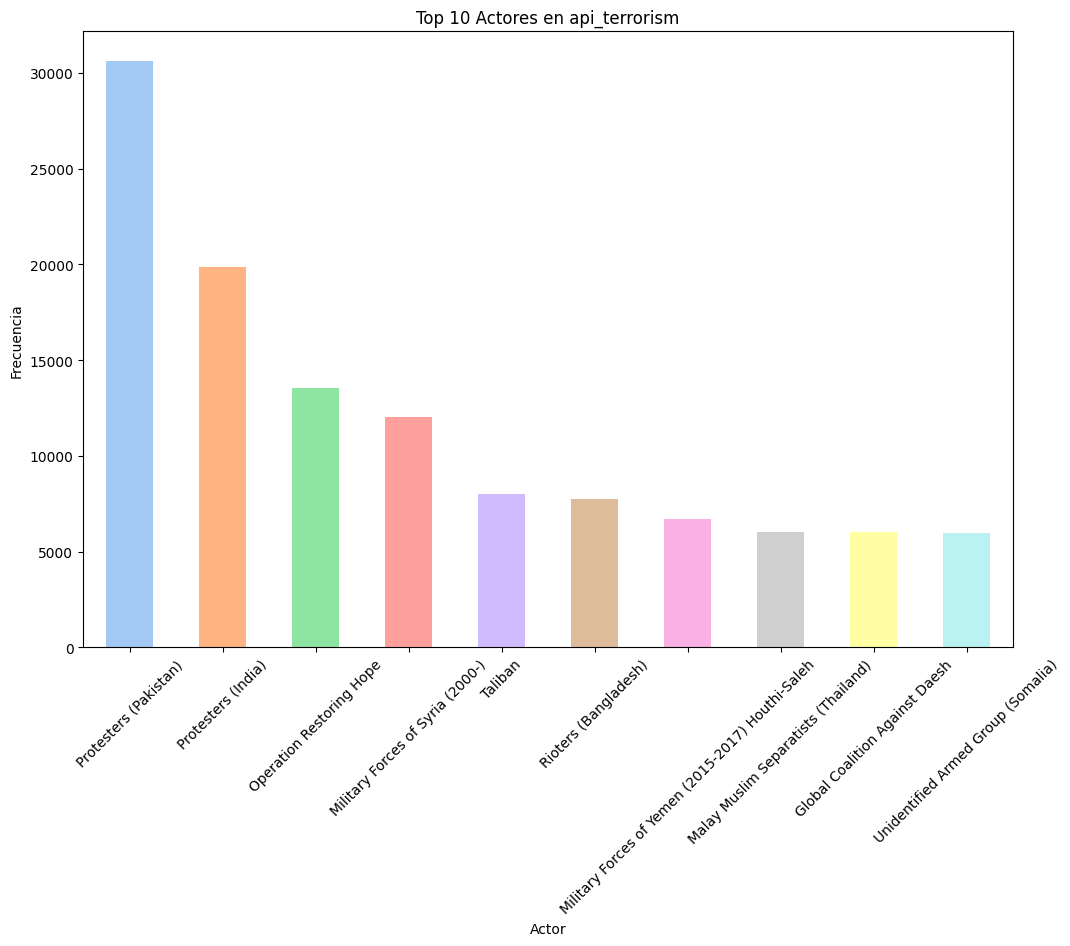

In [27]:
pastel_colors = sns.color_palette("pastel")

plt.figure(figsize=(12, 8))
actor_counts.plot(kind='bar', color=pastel_colors[:len(actor_counts)])
plt.title('Top 10 Actores en api_terrorism')
plt.xlabel('Actor')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

Para sorpresa nuestra, la API toma como eventos violentos protestas ocurridos sobre todo ocurridas en Asia del Sur, y teniendo en cuenta que la gran mayoría de eventos violentos son por violencia politica, pueden darnos un indicio de que, posiblemente, hayan violaciones en Asia del Sur al derecho de protesta. O al contrario, puede que utilicen los grupos politicos provoquen esas protestas para generar violencia por algún motivo, y resultar en esos eventos violentos.

## **Merge transformations**


Este código realiza una operación de fusión (merge) entre los DataFrames df_terrorism y api_terrorism, utilizando la columna date_country_actor como clave común para combinar los datos. La fusión se realiza con la opción how='left', lo que significa que se mantendrán todas las filas del DataFrame df_terrorism, y se agregarán las columnas correspondientes de api_terrorism cuando coincidan los valores en la columna date_country_actor. Si no hay coincidencia, se insertarán valores nulos (NaN) en las columnas del DataFrame derecho (api_terrorism). La columna objetivo después del merge será disorder_type

In [15]:
data = pd.merge(df_terrorism, api_terrorism, how='left', on='date_country_actor')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96271 entries, 0 to 96270
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   eventid             96271 non-null  int64         
 1   iyear               96271 non-null  int64         
 2   imonth              96271 non-null  int64         
 3   iday                96271 non-null  int64         
 4   extended            96271 non-null  int64         
 5   country_txt         96271 non-null  object        
 6   country_x           96271 non-null  int64         
 7   region_txt          96271 non-null  object        
 8   region              96271 non-null  int64         
 9   city                96271 non-null  object        
 10  latitude            96271 non-null  float64       
 11  longitude           96271 non-null  float64       
 12  vicinity            96271 non-null  int64         
 13  crit1               96271 non-null  int64     

In [17]:
data.head(5)

,eventid,iyear,imonth,iday,extended,country_txt,country_x,region_txt,region,city,...,property,ishostkid,nwound,INT_ANY,date,date_country_actor,event_date,country_y,disorder_type,actor1
0,197001010002,1970,1,1,0,United States,217,North America,1,Cairo,...,1,0.0,0.0,-9,1970-01-01,1970-01-01United StatesBlack Nationalists,NaN,NaN,NaN,NaN
1,197001020001,1970,1,2,0,Uruguay,218,South America,3,Montevideo,...,0,0.0,0.0,0,1970-01-02,1970-01-02UruguayTupamaros (Uruguay),NaN,NaN,NaN,NaN
2,197001020003,1970,1,2,0,United States,217,North America,1,Madison,...,1,0.0,0.0,0,1970-01-02,1970-01-02United StatesNew Year's Gang,NaN,NaN,NaN,NaN
3,197001030001,1970,1,3,0,United States,217,North America,1,Madison,...,1,0.0,0.0,0,1970-01-03,1970-01-03United StatesNew Year's Gang,NaN,NaN,NaN,NaN
4,197001090001,1970,1,9,0,United States,217,North America,1,Detroit,...,1,0.0,0.0,-9,1970-01-09,1970-01-09United StatesLeft-Wing Militants,NaN,NaN,NaN,NaN


In [18]:
data = data.dropna()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13969 entries, 18097 to 96265
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   eventid             13969 non-null  int64         
 1   iyear               13969 non-null  int64         
 2   imonth              13969 non-null  int64         
 3   iday                13969 non-null  int64         
 4   extended            13969 non-null  int64         
 5   country_txt         13969 non-null  object        
 6   country_x           13969 non-null  int64         
 7   region_txt          13969 non-null  object        
 8   region              13969 non-null  int64         
 9   city                13969 non-null  object        
 10  latitude            13969 non-null  float64       
 11  longitude           13969 non-null  float64       
 12  vicinity            13969 non-null  int64         
 13  crit1               13969 non-null  int64      

In [21]:
data.head(5)

,eventid,iyear,imonth,iday,extended,country_txt,country_x,region_txt,region,city,...,property,ishostkid,nwound,INT_ANY,date,date_country_actor,event_date,country_y,disorder_type,actor1
18097,201003120016,2010,3,12,1,Cameroon,37,Sub-Saharan Africa,11,Bakassi district,...,-9,1.0,2.0,1,2010-03-12,2010-03-12CameroonAfrica Marine Commando,2010-03-12,Cameroon,Political violence,Africa Marine Commando
18098,201003120016,2010,3,12,1,Cameroon,37,Sub-Saharan Africa,11,Bakassi district,...,-9,1.0,2.0,1,2010-03-12,2010-03-12CameroonAfrica Marine Commando,2010-03-12,Cameroon,Political violence,Africa Marine Commando
21311,201011160013,2010,11,16,1,Cameroon,37,Sub-Saharan Africa,11,Bakassi district,...,0,0.0,0.0,-9,2010-11-16,2010-11-16CameroonAfrica Marine Commando,2010-11-16,Cameroon,Political violence,Africa Marine Commando
21312,201011160013,2010,11,16,1,Cameroon,37,Sub-Saharan Africa,11,Bakassi district,...,0,0.0,0.0,-9,2010-11-16,2010-11-16CameroonAfrica Marine Commando,2010-11-16,Cameroon,Political violence,Africa Marine Commando
21313,201011160013,2010,11,16,1,Cameroon,37,Sub-Saharan Africa,11,Bakassi district,...,0,0.0,0.0,-9,2010-11-16,2010-11-16CameroonAfrica Marine Commando,2010-11-16,Cameroon,Political violence,Africa Marine Commando


Podemos observar que el resultado del merge son 13 mil datos. Se puede definir un manejo de datos nulos, tomando en cuenta de los otros 70 mil datos pueden ser reemplazados por 'Desconocido' para persistir la data original. Sin embargo, para objetivos del EDA de la API, perservaremos solo los datos del merge, esto tomando en cuenta el ver como cambió el gráfico de disorder_type del merge con respecto al original de la API.

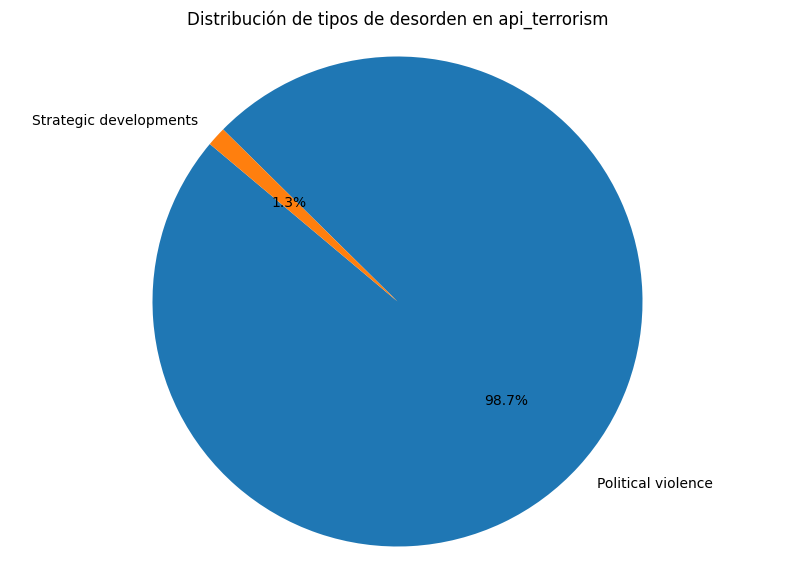

In [28]:
disorder_counts_merge = data['disorder_type'].value_counts()

plt.figure(figsize=(10, 7))
plt.pie(disorder_counts_merge, labels=disorder_counts_merge.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de tipos de desorden en api_terrorism')
plt.axis('equal')  
plt.show()

In [29]:
data['disorder_type'].unique()

array(['Political violence', 'Strategic developments'], dtype=object)

Podemos observar que, en su gran mayoría, después de la complementación del merge, sin tener en cuenta el número de 'Desconocidos' (notese que desconocidos será el resultado más alto debido a la gran cantidad de datos nulos que hay después del merge), el tipo de desorden será violencia politica con un absoluto porcentaje alto, y Strategic developments con un porcentaje extremadamente bajo. Lo que quiere decir que en nuestra complementación, se analizarán algunos casos sobre violencia politica en su inmensa mayoría. Esto puede servir para reconocer las variables que pueden ser incidentes para clasificar este tipo de violencia.